In [1]:
import pandas as pd
import numpy as np

In [2]:
import os, shutil

In [3]:
original_dataset_dir='/home/oleksii/Projects/SkinCancer/all'
base_dir='/home/oleksii/Projects/SkinCancer/img_splited'

In [4]:
train_dir = os.path.join(base_dir,'train')
train_mask_dir = os.path.join(base_dir,'train_mask')

validation_dir = os.path.join(base_dir,'validation')
validation_mask_dir = os.path.join(base_dir,'validation_mask')

test_dir = os.path.join(base_dir, 'test')

train_nev_dir=os.path.join(train_dir,'nev')
train_mel_dir=os.path.join(train_dir,'mel')
train_mask_nev_dir=os.path.join(train_mask_dir,'nev')
train_mask_mel_dir=os.path.join(train_mask_dir,'mel')

train_ot_dir = os.path.join(train_dir,'other')
train_mask_ot_dir = os.path.join(train_mask_dir,'other')

In [5]:
test_nev_dir=os.path.join(test_dir,'nev')
test_mel_dir=os.path.join(test_dir,'mel')

val_nev_dir=os.path.join(validation_dir,'nev')
val_mel_dir=os.path.join(validation_dir,'mel')

val_mask_nev_dir=os.path.join(validation_mask_dir,'nev')
val_mask_mel_dir=os.path.join(validation_mask_dir,'mel')
val_mask_ot_dit = os.path.join(validation_mask_dir,'other')

val_ot_dir = os.path.join(validation_dir,'other')

splitting files

# Preprocessing images

## Removing duplicates by MD5

In [44]:
import hashlib 

def md5(fname):
    hash_md5 = hashlib.md5()
    with open(fname, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

In [46]:
from os import listdir
from os.path import isfile, join
test_files = [f for f in listdir(test_nev_dir) if isfile(join(test_nev_dir, f))]
train_files = [f for f in listdir(train_nev_dir) if isfile(join(train_nev_dir, f))]

nev_to_delete = 0
for train_file in train_files:
    for test_file in test_files:
        train_full = os.path.join(train_nev_dir, train_file)
        test_full = os.path.join(test_nev_dir, test_file)
        train_hash = md5(train_full)
        test_hash = md5(test_full)
        if train_hash == test_hash:
            os.remove(test_full)
            nev_to_delete +=1
            
print('Nevus to delete:', nev_to_delete)

Nevus to delete: 0


In [ ]:
test_files = [f for f in listdir(test_mel_dir) if isfile(join(test_mel_dir, f))]
train_files = [f for f in listdir(train_mel_dir) if isfile(join(train_mel_dir, f))]

mel_to_delete = 0
for train_file in train_files:
    for test_file in test_files:
        train_full = os.path.join(train_mel_dir, train_file)
        test_full = os.path.join(test_mel_dir, train_file)
        train_hash = md5(train_full)
        test_hash = md5(test_full)
        if train_hash == test_hash:
            os.remove(test_full)
            mel_to_delete += 1
            
print('Melanoma to delete:', mel_to_delete)

# Building network

In [6]:
from keras import layers
from keras import models

/home/oleksii/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Using inception with freeze

In [7]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
conv_base = InceptionV3(weights='imagenet', include_top=False,input_shape=(155,155,3))
conv_base.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 155, 155, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 77, 77, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 77, 77, 32)    96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 77, 77, 32)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [8]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


In [9]:
from keras import optimizers

data_gen_args =  dict(rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

train_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)


test_datagen = ImageDataGenerator(rescale=1./255)
mask_test_datagen = ImageDataGenerator(rescale=1./255)


In [21]:
seed = 1

size=155

image_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(size,size),
    batch_size=30, class_mode='categorical', 
    seed=seed, shuffle=True)


val_img_generator = test_datagen.flow_from_directory(validation_dir,
                                                    target_size=(size,size),
                                                    batch_size=20, 
                                                    class_mode='categorical', 
                                                     seed=seed, shuffle=True)



Found 6916 images belonging to 3 classes.
Found 6628 images belonging to 3 classes.
Found 2938 images belonging to 3 classes.
Found 2855 images belonging to 3 classes.
[0 0 0 ... 2 2 2]


In [22]:
len(conv_base.layers)

311

In [23]:
for layer in conv_base.layers[:150]:
    layer.trainable = False
for layer in conv_base.layers[150:]:
    layer.trainable = True

In [24]:
from keras import layers
from keras import models
from keras import regularizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(3, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 387       
Total para

In [25]:
from keras.models import model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [28]:
from keras.callbacks import ModelCheckpoint
from PIL import ImageFile
from keras import optimizers

ImageFile.LOAD_TRUNCATED_IMAGES = True

adam_op = optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])


filepath="weights-skinscan-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
history = model.fit_generator(image_generator, steps_per_epoch=50,epochs=40,
                             validation_data=val_img_generator, validation_steps=50,callbacks=callbacks_list)


Epoch 1/40
50/50 [==============================] - 704s - loss: 0.7017 - acc: 0.7013 - val_loss: 3.1495 - val_acc: 0.6050
Epoch 2/40
50/50 [==============================] - 662s - loss: 0.6787 - acc: 0.7100 - val_loss: 1.9684 - val_acc: 0.6463
Epoch 3/40
50/50 [==============================] - 661s - loss: 0.6075 - acc: 0.7267 - val_loss: 1.0189 - val_acc: 0.6650
Epoch 4/40
50/50 [==============================] - 664s - loss: 0.5983 - acc: 0.7386 - val_loss: 0.7526 - val_acc: 0.7220
Epoch 5/40
50/50 [==============================] - 664s - loss: 0.5954 - acc: 0.7467 - val_loss: 0.8577 - val_acc: 0.6904
Epoch 6/40
50/50 [==============================] - 664s - loss: 0.5932 - acc: 0.7513 - val_loss: 0.6569 - val_acc: 0.7600
Epoch 7/40
50/50 [==============================] - 664s - loss: 0.5425 - acc: 0.7787 - val_loss: 0.6783 - val_acc: 0.7184
Epoch 8/40
50/50 [==============================] - 661s - loss: 0.5848 - acc: 0.7444 - val_loss: 0.6334 - val_acc: 0.7360
Epoch 9/40
50/50

In [29]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("weights-skinscan-36-0.82.hdf5")
print("Loaded model from disk")
 

Loaded model from disk


In [30]:
from keras import optimizers


# evaluate loaded model on test data
adam_op = optimizers.Adam(lr=0.0001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['acc'])

In [31]:
import platform 
print(platform.python_version())

3.6.4


In [32]:
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

img_path = 'ISIC_0000142.jpg'
img = image.load_img(img_path, target_size=(155, 155))

# TO TRY!!!!!!!!!!!!!
#print(img)
x = image.img_to_array(img)
#print(x)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = loaded_model.predict(x)[0]
print(preds)

[0.50352186 0.7488835  0.05768626]


In [33]:
from PIL import Image

img_path = 'ISIC_0000142.jpg'
image_pil = Image.open(img_path)
print('image opened')

hw_tuple = (155, 155)
if image_pil.size != hw_tuple:
    image_pil = image_pil.resize(hw_tuple)

print('image resized')

            # Add logic to change input to (150,150,3)
            # Add logic to make normalization 1/255

img_array = image.img_to_array(image_pil)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
print('image preprocessed')
preds = loaded_model.predict(img_array)[0]
print(preds)

image opened
image resized
image preprocessed
[0.50352186 0.7488835  0.05768626]


In [34]:
image_pil.save('resized.jpeg')

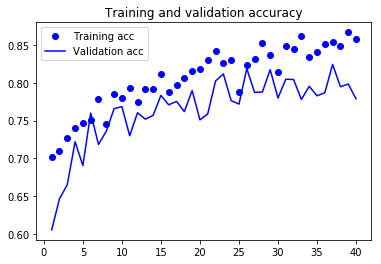

In [35]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs= range(1, len(acc) + 1)
plt.plot(epochs, acc,'bo',label='Training acc')
plt.plot(epochs, val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')

plt.legend()
plt.figure()

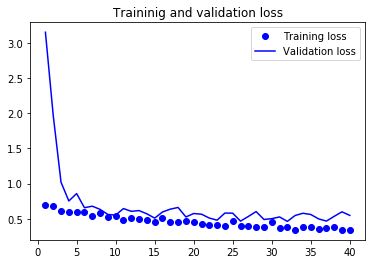

In [36]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss,'b',label='Validation loss')
plt.title('Traininig and validation loss')
plt.legend()

plt.show()

In [37]:
model.save('skinscan_final.h5')